# Computer Generated Hologram

## 0. Prepare

In [86]:
import sys
import numpy as np
from scipy.fftpack import fft2, ifft2, fftshift, ifftshift
import matplotlib.pyplot as plt
import cv2 as cv
from PIL import Image

In [87]:
# import custom modules
sys.path.append("../module")
from MetaTool import norm

## 1. Constants, classes and functions

In [88]:
# colorbar setting
cmap_amp = "Reds"  # amplitude use
cmap_ang = "RdBu_r"  # angle (phase) use

In [89]:
class GS:
    """ 
    Gerchberg-Saxton (GS) algorithm for phase-only hologram
    """
    def __init__(self, pattern_amplitude_dest, init_type=0, fix_value=1):
        """ 
        Initialize
        @param pattern_amplitude_dest: destination pattern (amplitude) in frequency domain, 2D array of real number
        @param init_type: 0 (random), 1 (fix value: `fix_value`)
        @param fix_value: used when init_type = 1. Default: 1
        """
        self.pattern_amplitude_dest = np.array(pattern_amplitude_dest)
        self.rows, self.cols = self.pattern_amplitude_dest.shape
        # normalized frequency amplitude matrix
        self.frequency_dest_amplitude = (self.pattern_amplitude_dest - np.min(self.pattern_amplitude_dest)) \
            / (np.max(self.pattern_amplitude_dest) - np.min(self.pattern_amplitude_dest))
        # holography initialization
        self.space_amplitude = np.ones((self.rows, self.cols))  # fixed
        if init_type == 0:
            self.space_phase = 2 * np.pi * np.random.rand(self.rows, self.cols) - np.pi  # randomly initialized at [-\pi, \pi)
        elif init_type == 1:
            self.space_phase = fix_value * np.ones((self.rows, self.cols))
        else:
            assert False, "Illegal value for `init_type`."
        self.space_phase_init = self.space_phase.copy()
        # optimization params
        self.rmse_vec = None  # RMSE vector in the iteration
        self.rmse_best = np.inf  # best RMSE in the iteration
        self.space_phase_best = self.space_phase  # best phase profile


    def iterate(self, epoch_max=500, epsilon=0.01, best=False):
        """ 
        Iterate to solve the phase profile
        @param epoch_max: maximum iteration count. Default: 200
        @param epsilon: the early finishing condition for the RMSE threshold. Default: 0.01
        @param best: best or last. Default: False
        @return: optimized phase profile in the spatial domain
        """
        if self.rmse_vec == None:
            self.rmse_vec = []  # initialize
        for i in range(epoch_max):
            space_profile = self.space_amplitude * np.exp(1j * self.space_phase)
            frequency_recover_profile = fftshift(fft2((space_profile)))
            frequency_profile = self.frequency_dest_amplitude * np.exp(1j * np.angle(frequency_recover_profile))
            space_profile = ifft2(ifftshift(frequency_profile))
            self.space_phase = np.angle(space_profile)
            # calculate rmse
            temp = np.abs(frequency_recover_profile)
            frequency_recover_amplitude_norm = (temp - np.min(temp)) / (np.max(temp) - np.min(temp))
            self.rmse_vec.append(
                np.sqrt(np.mean((self.frequency_dest_amplitude - frequency_recover_amplitude_norm) ** 2)))
            if self.rmse_vec[-1] <= epsilon:
                break
            if self.rmse_vec[-1] < self.rmse_best:
                self.rmse_best = self.rmse_vec[-1]
                self.space_phase_best = self.space_phase
        return self.space_phase_best if best else self.space_phase


    def rmse(self, best=False):
        """
        Return the current RMSE value
        @param best: best or last. Default: False
        @return: RMSE
        """
        if self.rmse_vec != None:
            return self.rmse_best if best else self.rmse_vec[-1]


    def recover(self, best=False):
        """ 
        Recover the frequency profile using the current phase profile
        @param best: best or last. Default: False
        @return: frequency profile (2D array)
        """
        if best:
            return fftshift(fft2(self.space_amplitude * np.exp(1j * self.space_phase_best)))
        else:
            return fftshift(fft2(self.space_amplitude * np.exp(1j * self.space_phase)))

In [90]:
def getFov(wavelength, unit_length):
    """ 
    Return FOV of current wavelength and unit length of metasurface
    @param wavelength: wavelength [m]
    @param unit_length: unit length of meta [m]
    @return: FOV [rad]
    """
    return 2 * np.arcsin(wavelength / 2 / unit_length) if wavelength / 2 < unit_length else np.pi

In [91]:
def correctDistortion(image, wavelength, unit_length):
    """ 
    Correct the distortion of image
    @param image: image (2D array) to be corrected
    @param wavelength: wavelength [m]
    @param unit_length: unit length of meta [m]
    @return: corrected image (2D array)
    """
    rows, cols = image.shape
    temp1 = (wavelength / 2 / unit_length) ** 2
    image_distortion = np.zeros_like(image)
    for i in range(rows):
        for j in range(cols):
            y = i - rows / 2  # origin of (x, y) is the center of image
            x = j - cols / 2
            # temp2 = np.sqrt(1 + (x ** 2 * 4 / (cols ** 2) + y ** 2 * 4 / (rows ** 2)) * temp1)
            temp2 = np.sqrt(1 + (x ** 2 + y ** 2) / (rows ** 2 / 4 + cols ** 2 / 4) * temp1)
            ii = round(y / temp2 + rows / 2)
            jj = round(x / temp2 + cols / 2)
            if 0 <= jj < cols and 0 <= ii < rows:
                image_distortion[ii, jj] = image[i, j]
    return image_distortion

In [92]:
def correctIntensity(image, wavelength, unit_length, beta=3, distortion_later=True):
    """ 
    Correct the FOV intensity problem of image
    @param image: origin image [2D array]
    @param wavelength: wavelength [m]
    @param unit_length: unit length of meta [m]
    @param beta: cosine power factor. Default: 3
    @param distortion_later: whether distortion correction will be processed later (corresponding to different correction equations). Default: True
    @return: corrected image
    """
    if distortion_later:
        temp1 = wavelength / 2 / unit_length
        rows, cols = image.shape
        image_cor = np.zeros(image.shape, dtype=np.float_)
        for i in range(rows):
            for j in range(cols):
                y = i - rows / 2
                x = j - cols / 2
                theta = np.arctan(temp1 * np.sqrt((2 * x / cols) ** 2 + (2 * y / rows) ** 2))
                image_cor[i, j] = image[i, j] / (np.cos(theta) ** beta)
        return cv.normalize(image_cor, None, 0, 255, cv.NORM_MINMAX).astype(np.uint8)
    else:
        temp1 = np.sin(getFov(wavelength, unit_length) / 2)
        rows, cols = image.shape
        image_cor = np.zeros(image.shape, dtype=np.float_)
        for i in range(rows):
            for j in range(cols):
                y = i - rows / 2
                x = j - cols / 2
                temp2 = temp1 * np.sqrt((2 * x / cols) ** 2 + (2 * y / rows) ** 2)
                if temp2 <= 1:
                    theta = np.arcsin(temp2)
                else:
                    theta = np.pi / 2
                image_cor[i, j] = image[i, j] / (np.cos(theta) ** beta)
        return cv.normalize(image_cor, None, 0, 255, cv.NORM_MINMAX).astype(np.uint8)

## 2. Computer-generated hologram without wide-FOV correction

In [93]:
# import destination frequency pattern
pattern_dest = np.array(Image.open("../data/h_pattern.png"))[:, :, 0]  # use only the red component of RGBA image
# here we use a 20*20 pattern as an example, which will be used in other notebooks
pattern_dest = pattern_dest[::6, ::6]
pattern_dest = norm(pattern_dest)  # normalize to 0-1
# convert from intensity to amplitude
pattern_amplitude_dest = np.sqrt(pattern_dest)

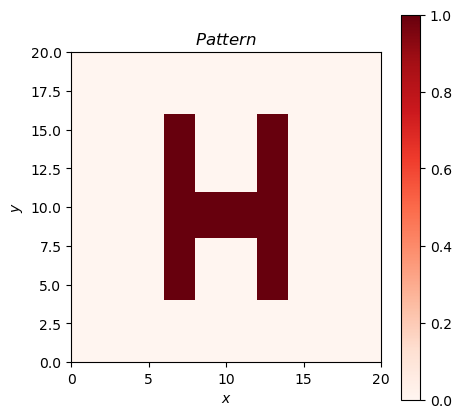

In [94]:
# draw pattern (intensity)
fig = plt.figure(figsize=(5, 5))
c = plt.pcolor(pattern_dest, cmap=cmap_amp)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title(r"$Pattern$")
fig.colorbar(c)
plt.gca().set_aspect(1)
plt.show()

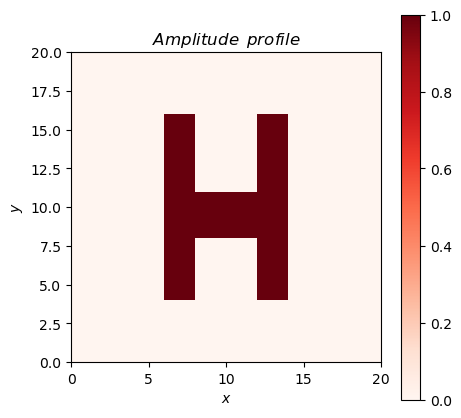

In [95]:
# draw pattern (amplitude)
fig = plt.figure(figsize=(5, 5))
c = plt.pcolor(pattern_amplitude_dest, cmap=cmap_amp)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title(r"$Amplitude \enspace profile$")
fig.colorbar(c)
plt.gca().set_aspect(1)
plt.show()

In [96]:
gs = GS(pattern_amplitude_dest, init_type=0)
space_phase_profile_dest = gs.iterate(epoch_max=500, epsilon=0.01)
pattern_complex_recover = gs.recover()
pattern_amplitude_recover = np.abs(pattern_complex_recover)
pattern_recover = pattern_amplitude_recover ** 2

In [97]:
gs.rmse()  # print the current RMSE

0.10393596222963208

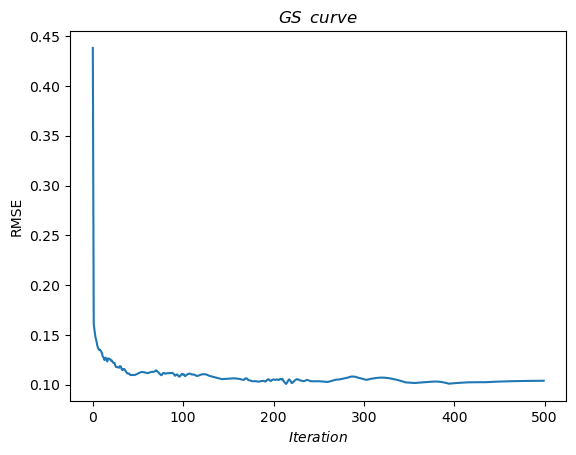

In [98]:
# draw the RMSE curve over the iteration
plt.plot(gs.rmse_vec)
plt.xlabel(r"$Iteration$")
plt.ylabel(r"RMSE")
plt.title(r"$GS \enspace curve$")
plt.show()

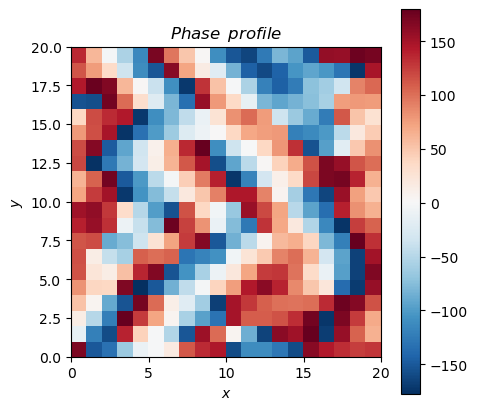

In [99]:
# draw phase profile optimized
fig = plt.figure(figsize=(5, 5))
c = plt.pcolor(np.rad2deg(space_phase_profile_dest), cmap=cmap_ang)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title(r"$Phase \enspace profile$")
fig.colorbar(c)
plt.gca().set_aspect(1)
plt.show()

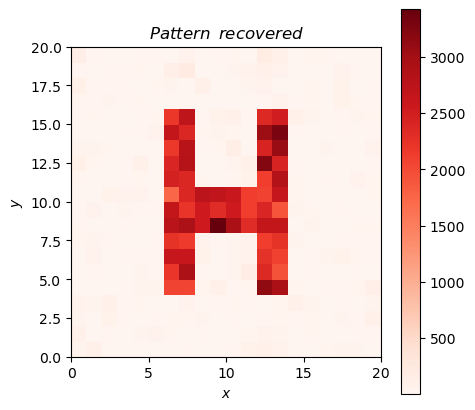

In [100]:
# draw pattern (intensity) recovered
fig = plt.figure(figsize=(5, 5))
c = plt.pcolor(pattern_recover, cmap=cmap_amp)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title(r"$Pattern \enspace recovered$")
fig.colorbar(c)
plt.gca().set_aspect(1)
plt.show()

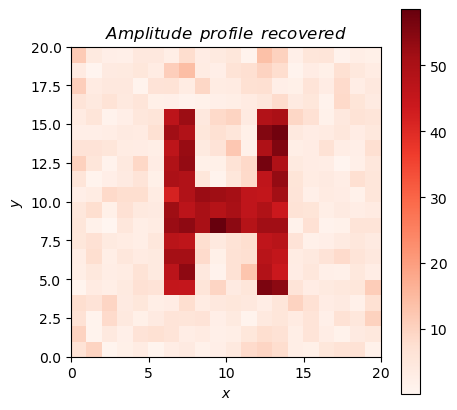

In [101]:
# draw pattern (amplitude) recovered
fig = plt.figure(figsize=(5, 5))
c = plt.pcolor(pattern_amplitude_recover, cmap=cmap_amp)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title(r"$Amplitude \enspace profile \enspace recovered$")
fig.colorbar(c)
plt.gca().set_aspect(1)
plt.show()

In [102]:
# save the result
np.save("../data/hologram_phase_20_20.npy", space_phase_profile_dest)

## 3. Computer-generated hologram with wide-FOV correction

In [103]:
# import destination frequency pattern
pattern_dest = np.array(Image.open("../data/h_pattern.png"))[:, :, 0]  # use only the red component of RGBA image
pattern_dest = norm(pattern_dest)  # normalize to 0-1
# convert from intensity to amplitude
pattern_amplitude_dest = np.sqrt(pattern_dest)

# wide-FOV correction
pattern_dest = correctIntensity(pattern_dest, wavelength=633e-9, unit_length=300e-9, beta=4)
pattern_dest = correctDistortion(pattern_dest, wavelength=633e-9, unit_length=300e-9)
pattern_dest = norm(pattern_dest)  # normalize to 0-1

# convert from intensity to amplitude
pattern_amplitude_dest = np.sqrt(pattern_dest)

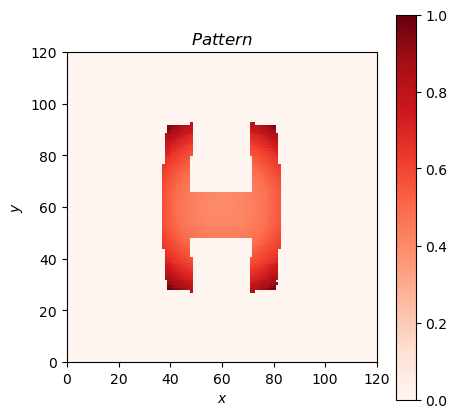

In [104]:
# draw pattern (intensity)
fig = plt.figure(figsize=(5, 5))
c = plt.pcolor(pattern_dest, cmap=cmap_amp)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title(r"$Pattern$")
fig.colorbar(c)
plt.gca().set_aspect(1)
plt.show()

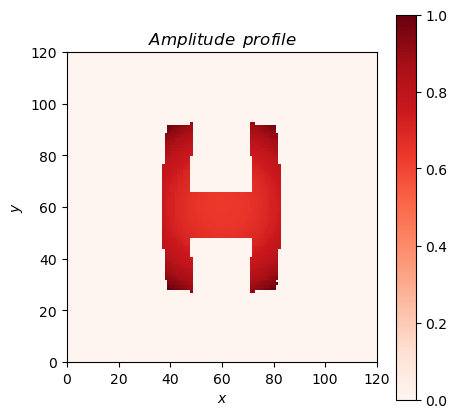

In [105]:
# draw pattern (amplitude)
fig = plt.figure(figsize=(5, 5))
c = plt.pcolor(pattern_amplitude_dest, cmap=cmap_amp)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title(r"$Amplitude \enspace profile$")
fig.colorbar(c)
plt.gca().set_aspect(1)
plt.show()

In [106]:
gs = GS(pattern_amplitude_dest, init_type=0)
space_phase_profile_dest = gs.iterate(epoch_max=500, epsilon=0.01)
pattern_complex_recover = gs.recover()
pattern_amplitude_recover = np.abs(pattern_complex_recover)
pattern_recover = pattern_amplitude_recover ** 2

In [107]:
gs.rmse()

0.07130000194242302

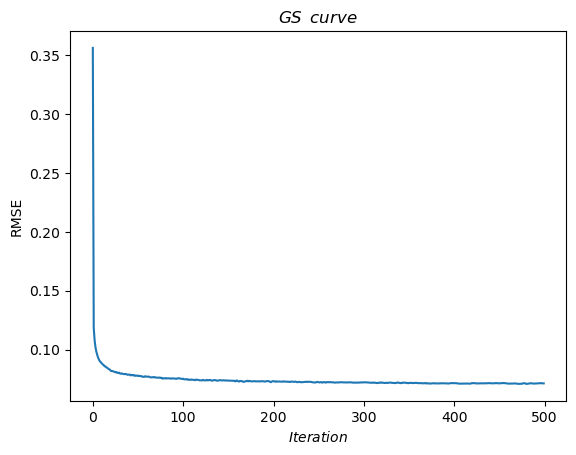

In [108]:
plt.plot(gs.rmse_vec)
plt.xlabel(r"$Iteration$")
plt.ylabel(r"RMSE")
plt.title(r"$GS \enspace curve$")
plt.show()

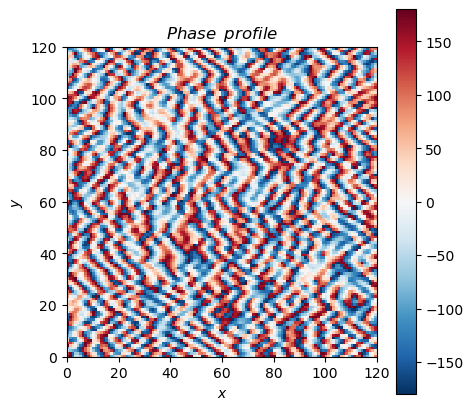

In [109]:
# draw phase profile optimized
fig = plt.figure(figsize=(5, 5))
c = plt.pcolor(np.rad2deg(space_phase_profile_dest), cmap=cmap_ang)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title(r"$Phase \enspace profile$")
fig.colorbar(c)
plt.gca().set_aspect(1)
plt.show()

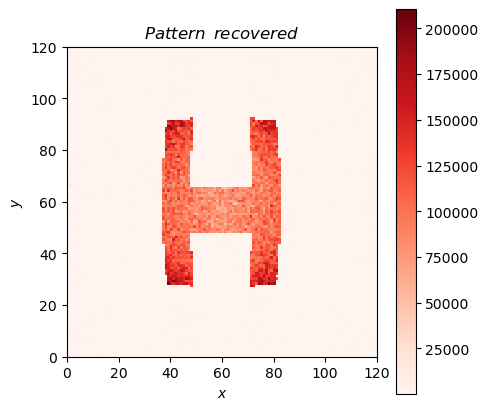

In [110]:
# draw pattern (intensity) recovered
fig = plt.figure(figsize=(5, 5))
c = plt.pcolor(pattern_recover, cmap=cmap_amp)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title(r"$Pattern \enspace recovered$")
fig.colorbar(c)
plt.gca().set_aspect(1)
plt.show()

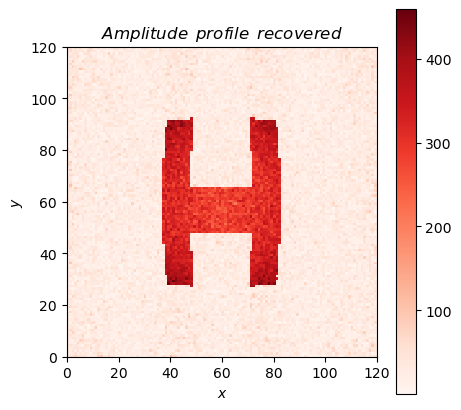

In [111]:
# draw pattern (amplitude) recovered
fig = plt.figure(figsize=(5, 5))
c = plt.pcolor(pattern_amplitude_recover, cmap=cmap_amp)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title(r"$Amplitude \enspace profile \enspace recovered$")
fig.colorbar(c)
plt.gca().set_aspect(1)
plt.show()

In [112]:
np.save("../data/hologram_phase_correct_120_120.npy", space_phase_profile_dest)

The diffraction pattern on the observation plane (calculated by the Rayleigh–Sommerfeld diffraction formula) of this corrected hologram 
will be distortion and intensity corrected.